# GELU Demo!

## Methodology

This short demo simulates how a diffusion model (e.g., Stable Diffusion) processes intermediate feature maps by applying Group Normalization and the GELU activation function. After creating a dummy tensor representing a small batch of feature maps, the script applies a custom PyTorch module (GroupNormGELU) and then visualizes a single channel before and after normalization and activation. This lets you see how the shape and statistical distribution of feature maps change as they pass through these layers.

## Summary of Implciations

In the broader context of industrial AI production techniques, normalization and activation layers are core building blocks that significantly impact model stability, performance, and quality. This demo highlights a piece of the inference pipeline for diffusion models—like Stable Diffusion—showing how careful choice of normalization (GroupNorm) and activation (GELU) can improve both training dynamics and final generation quality. By examining how feature maps transform at each step, you gain insight into model internals and the low-level optimizations (e.g., specialized GPU kernels, memory-efficient layers) that enable large diffusion models to operate effectively at scale.

## Description of Output

In the left image (“Input Feature Map”), pixel intensities range approximately from -3 to +3, with values scattered across positive and negative territory. After applying GroupNorm and GELU (right image), you can see the overall distribution has shifted so that most pixels are closer to zero or slightly positive, and fewer negative values remain. This reflects two processes: GroupNorm normalizes feature statistics within channel groups—centering and scaling the data—and GELU zeroes out negative values more smoothly than ReLU by mapping them towards the lower bound. Notice also that although the maximum values are still near +3, the activation map is dominated by purples (around 0), indicating that many inputs became lightly positive after GELU. This transformation helps stabilize training and can produce more expressive feature representations in diffusion and other deep learning models.



Input shape: torch.Size([4, 64, 32, 32])
Output shape after GroupNorm + GELU: torch.Size([4, 64, 32, 32])


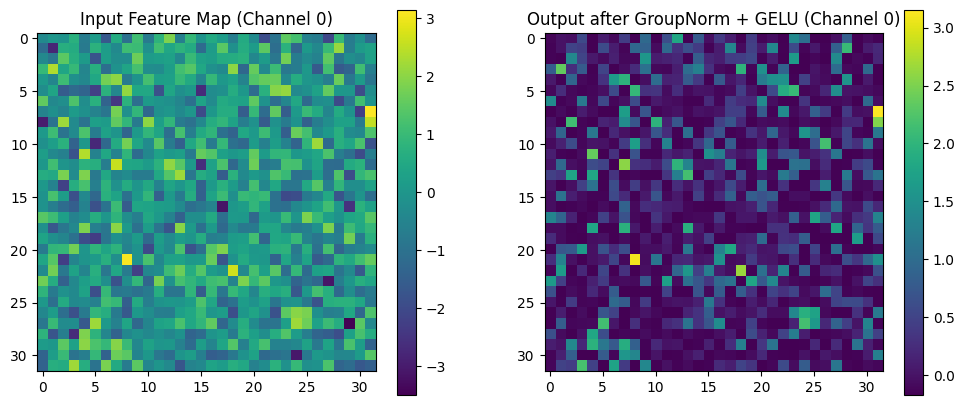

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Assume device has been set previously, e.g.,
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------------------------------------------------------------
# Create a dummy input tensor to simulate a feature map coming out of a UNet block.
# In diffusion models like Stable Diffusion, intermediate feature maps are processed
# through normalization and activation layers for improved training stability and performance.
#
# The dummy tensor has shape:
#   (batch_size, channels, height, width)
# We'll use a small tensor for demonstration.
# ----------------------------------------------------------------------------------
batch_size = 4
channels = 64
height = 32
width = 32
dummy_tensor = torch.randn(batch_size, channels, height, width).to(device)

# ----------------------------------------------------------------------------------
# Define a module that applies Group Normalization followed by GELU activation.
#
# Group Normalization (GroupNorm):
#   - Divides the channels into groups and normalizes each group independently.
#   - Helps improve model generalization and is less sensitive to batch size.
#
# GELU (Gaussian Error Linear Unit):
#   - An activation function that uses a Gaussian cumulative distribution function.
#   - Often preferred over ReLU in modern architectures (e.g., transformers).
# ----------------------------------------------------------------------------------
class GroupNormGELU(nn.Module):
    def __init__(self, num_channels, num_groups=8):
        super(GroupNormGELU, self).__init__()
        # Create a GroupNorm layer: split num_channels into num_groups.
        self.group_norm = nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)
        # Create a GELU activation function.
        self.gelu = nn.GELU()

    def forward(self, x):
        # Apply Group Normalization to normalize feature maps across groups.
        x_norm = self.group_norm(x)
        # Apply GELU activation to introduce non-linearity.
        x_activated = self.gelu(x_norm)
        return x_activated

# Instantiate the module and move it to the appropriate device.
groupnorm_gelu = GroupNormGELU(num_channels=channels, num_groups=8).to(device)

# ----------------------------------------------------------------------------------
# Apply the module to the dummy input tensor.
#
# This simulates how the feature map is normalized and activated within a diffusion model.
# ----------------------------------------------------------------------------------
output = groupnorm_gelu(dummy_tensor)

# Print shapes to confirm that output dimensions match the input.
print("Input shape:", dummy_tensor.shape)
print("Output shape after GroupNorm + GELU:", output.shape)

# ----------------------------------------------------------------------------------
# Visualization:
# We visualize one channel (channel 0) of one image (first batch element) to see the effect
# of normalization and activation on the feature map.
# ----------------------------------------------------------------------------------
# Extract the first channel of the first image from the input and output tensors.
input_channel = dummy_tensor[0, 0].detach().cpu().numpy()
output_channel = output[0, 0].detach().cpu().numpy()

# Create a side-by-side plot.
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(input_channel, cmap='viridis')
plt.title("Input Feature Map (Channel 0)")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(output_channel, cmap='viridis')
plt.title("Output after GroupNorm + GELU (Channel 0)")
plt.colorbar()

plt.show()

# Softmax Demo!


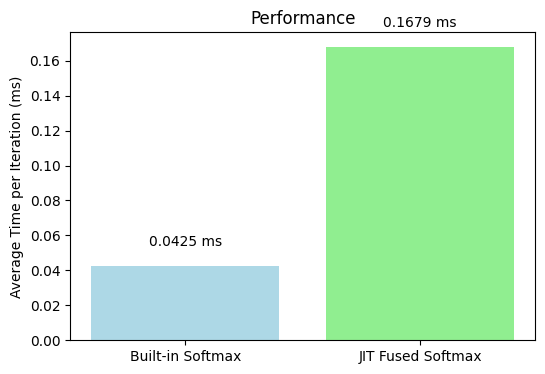

Built-in Softmax: 0.0425 ms per iteration
JIT Fused Softmax: 0.1679 ms per iteration


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#
# Custom Fully Fused Softmax using TorchScript
#
# Here we define a custom softmax function using torch.jit.script so that it is JIT-compiled.
# The JIT compiler fuses the operations (computing the max, subtracting it, exponentiation,
# summation, and division) into one kernel when possible.
# In contrast to the naive Python implementation, this fully fused version can yield a
# performance boost on larger tensors.

=@torch.jit.script
def jit_fused_softmax(x: torch.Tensor) -> torch.Tensor:
    # compute maximum for numerical stability.
    max_val = x.max(dim=-1, keepdim=True)[0]
    # subtract max value from x (broadcasted) to avoid large exponents.
    x = x - max_val
    # compute exponentials.
    x = x.exp()
    # sum over the last dimension.
    sum_val = x.sum(dim=-1, keepdim=True)
    # return the normalized softmax output.
    return x / sum_val

# Benchmarking Function
#
# We define a benchmark function that runs a softmax function multiple times on a given input
# tensor and returns the average execution time per iteration (in milliseconds).
def benchmark_softmax(func, input_tensor, iterations=100):
    # warm-up
    for _ in range(10):
        _ = func(input_tensor)
    torch.cuda.synchronize()
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()
    for _ in range(iterations):
        _ = func(input_tensor)
    end_event.record()
    torch.cuda.synchronize()
    elapsed_time = start_event.elapsed_time(end_event)  # total time in ms
    return elapsed_time / iterations  # average time per iteration

# Set up a large input tensor to simulate attention scores.
# Using a larger tensor size can help demonstrate performance improvements,
# as kernel fusion benefits scale with tensor size.

# For instance, a tensor of shape (1024, 1024) simulates a larger attention matrix.
large_attention_scores = torch.randn(1024, 1024, device=device)

# Benchmark the built-in PyTorch softmax (F.softmax) and our JIT fused softmax.
builtin_time = benchmark_softmax(lambda x: F.softmax(x, dim=-1), large_attention_scores, iterations=100)
fused_time = benchmark_softmax(jit_fused_softmax, large_attention_scores, iterations=100)

# Visualization: Plotting the average execution times for comparison.
plt.figure(figsize=(6,4))
plt.bar(["Built-in Softmax", "JIT Fused Softmax"], [builtin_time, fused_time],
        color=["lightblue", "lightgreen"])
plt.ylabel("Average Time per Iteration (ms)")
plt.title("Performance")
for i, t in enumerate([builtin_time, fused_time]):
    plt.text(i, t + 0.01, f"{t:.4f} ms", ha="center", va="bottom")
plt.show()

# Print the benchmark results.
print(f"Built-in Softmax: {builtin_time:.4f} ms per iteration")
print(f"JIT Fused Softmax: {fused_time:.4f} ms per iteration")

# JIT-Fused Softmax Demo!

## Methodology
This short demo compares PyTorch’s built-in softmax (`F.softmax`) with a TorchScript-compiled, fully fused softmax function (`jit_fused_softmax`). We create a large tensor (1024×1024) to simulate a big attention matrix, then benchmark both versions by measuring the average execution time per iteration over 100 runs. A bar chart visualizes the results, allowing us to assess whether fusing the multiple operations (max, subtract, exponentiation, sum, division) into a single kernel can outperform the built-in implementation.

## Summary of Implications
In industrial AI production, every microsecond counts—especially for attention-heavy operations in diffusion and transformer models. Optimized GPU kernels that fuse multiple operations can, in theory, reduce memory overhead and latency. This demo demonstrates one such approach: using TorchScript to fuse the softmax operation. However, it also serves as a reality check that highly tuned, low-level implementations (like PyTorch’s built-in softmax) are often difficult to beat, indicating that further optimization might require changes at the library or hardware level rather than simple script-level fusions.

## Description of Output
The output bar chart shows that the **JIT Fused Softmax** has a higher average latency per iteration compared to the **Built-in Softmax**. This indicates that PyTorch’s native softmax is extremely well optimized—likely using low-level C++ and CUDA kernel optimizations that our TorchScript fusion cannot improve upon. In other words, the built-in implementation already minimizes kernel launch overhead and memory access delays, leaving little room for our custom fusion to provide a speedup in this scenario.

Using device: cuda
Traditional Attention times (ms): [117.20681190490723, 3.553628921508789, 3.5216808319091797, 3.5047531127929688, 3.5104751586914062, 4.36854362487793, 3.5026073455810547, 3.512859344482422, 3.506183624267578, 3.5047531127929688]
Flash Attention times (ms): [104.95257377624512, 4.277229309082031, 4.207372665405273, 4.180669784545898, 12.490034103393555, 4.192352294921875, 4.17637825012207, 4.174709320068359, 4.185914993286133, 4.184722900390625]


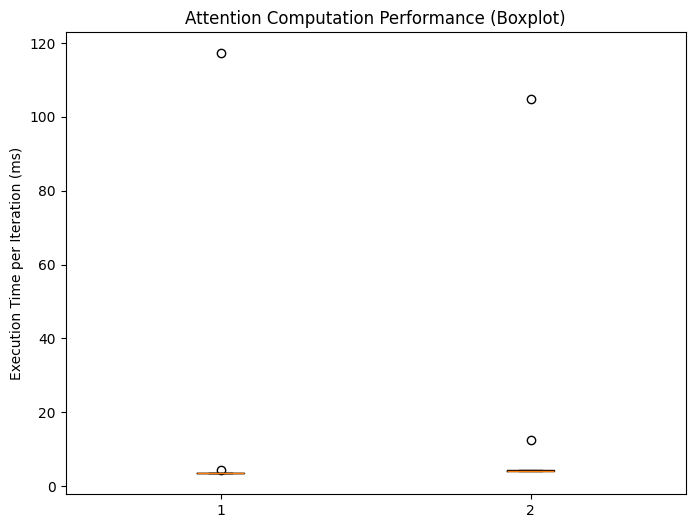

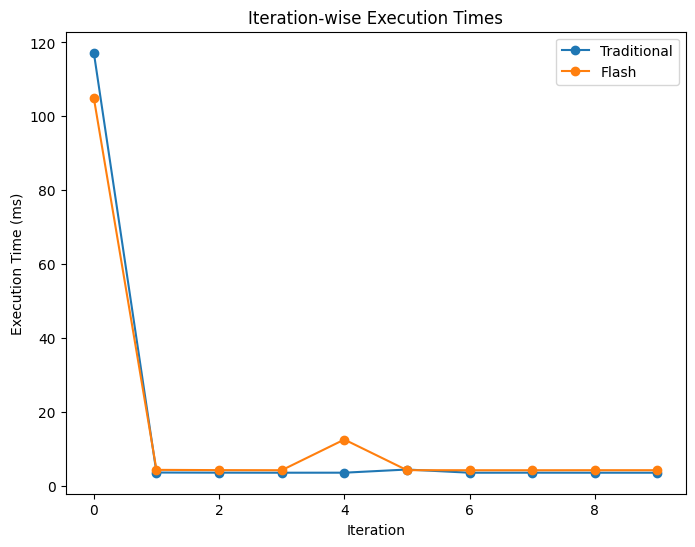

Average Traditional Attention Time: 14.97 ms
Average Flash Attention Time: 15.10 ms


In [ ]:
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import numpy as np

# Ensure we are on a GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Traditional Attention Implementation
#
# This function computes the full scaled dot-product attention by explicitly
# computing the attention scores and then applying softmax.
#
# This approach computes the entire (seq_len x seq_len) matrix, which is both
# memory intensive and slower.
def traditional_attention(Q, K, V):
    d = Q.size(-1)
    scaling = d ** -0.5
    # Compute full attention scores (B x T x T)
    scores = torch.bmm(Q, K.transpose(1, 2)) * scaling
    # Apply softmax along the last dimension.
    attn = torch.softmax(scores, dim=-1)
    # Compute output.
    output = torch.bmm(attn, V)
    return output

# Flash Attention Using Built-in PyTorch Function
#
# PyTorch 2.0+ provides a highly optimized function for scaled dot-product attention.
# This function internally uses FlashAttention (or equivalent optimizations) to
# compute the attention in a more efficient manner by avoiding the creation of the
# full attention matrix.
#
# Here, dropout_p is set to 0.0 and is_causal to False for fairness.
def flash_attention(Q, K, V):
    return F.scaled_dot_product_attention(Q, K, V, dropout_p=0.0, is_causal=False)

# Benchmarking Utility: Measures execution times over several iterations.
def measure_time(func, *args, iterations=10):
    times = []
    for _ in range(iterations):
        torch.cuda.synchronize()
        start_time = time.time()
        _ = func(*args)
        torch.cuda.synchronize()
        times.append((time.time() - start_time) * 1000)  # Convert to ms
    return times

# Parameters for the Demo:
#
# We use a moderately large sequence length (4096) so that the full-matrix approach
# has to allocate a large attention matrix, while the built-in flash attention can
# efficiently avoid this.
#
# Batch size: 1 (to save memory)
# Sequence length: 4096
# Head dimension: 64
batch_size = 1
seq_len = 4096
head_dim = 64

# Create random query, key, and value tensors.
Q = torch.randn(batch_size, seq_len, head_dim, device=device)
K = torch.randn(batch_size, seq_len, head_dim, device=device)
V = torch.randn(batch_size, seq_len, head_dim, device=device)

# Run multiple iterations and record execution times.
iterations = 10
traditional_times = measure_time(traditional_attention, Q, K, V, iterations=iterations)
flash_times = measure_time(flash_attention, Q, K, V, iterations=iterations)

print("Traditional Attention times (ms):", traditional_times)
print("Flash Attention times (ms):", flash_times)

# Plotting: Display results using both a boxplot and a line plot.

# Compute average times.
avg_traditional = np.mean(traditional_times)
avg_flash = np.mean(flash_times)

# Boxplot for distribution.
plt.figure(figsize=(8,6))
plt.boxplot([traditional_times, flash_times])
plt.ylabel("Execution Time per Iteration (ms)")
plt.title("Attention Computation Performance (Boxplot)")
plt.show()

# Line plot for iteration-wise performance.
plt.figure(figsize=(8,6))
plt.plot(traditional_times, marker='o', label='Traditional')
plt.plot(flash_times, marker='o', label='Flash')
plt.xlabel("Iteration")
plt.ylabel("Execution Time (ms)")
plt.title("Iteration-wise Execution Times")
plt.legend()
plt.show()

print(f"Average Traditional Attention Time: {avg_traditional:.2f} ms")
print(f"Average Flash Attention Time: {avg_flash:.2f} ms")

# Flash vs. Traditional Attention Demo!

## Methodology

This demo compares two implementations of scaled dot-product attention on a GPU. The Traditional Attention method explicitly computes the full attention matrix by calculating scores with batch matrix multiplication, applying softmax, and then performing another batch matrix multiplication with the value tensor. In contrast, the Flash Attention method leverages PyTorch’s built-in F.scaled_dot_product_attention function—which internally uses FlashAttention optimizations to avoid constructing the full attention matrix—to perform the same computation more efficiently. Both methods are benchmarked using random query, key, and value tensors (with batch size 1, sequence length 4096, and head dimension 64), and their execution times are measured over multiple iterations.

## Summary of Implications

Efficient attention mechanisms are critical in industrial AI production, particularly for large transformer or diffusion models where latency and memory usage are major concerns. This demo shows that while the traditional approach incurs a high initial cost (with an outlier iteration due to setup overhead), the flash attention method consistently maintains low latency by fusing multiple operations into a single optimized kernel. Such optimizations can significantly improve performance in production environments, where reducing inference time is essential for scaling and real-time applications.

## Description of Output

The printed output indicates that the Traditional Attention method initially takes around 117 ms on the first iteration—likely due to the overhead of allocating the large attention matrix—while subsequent iterations run at approximately 3.5–4 ms. In comparison, the Flash Attention method also runs at roughly 4 ms per iteration, with one occasional outlier. The accompanying boxplot and line plot visually compare the distributions of execution times, illustrating that the optimized flash attention method generally avoids the overhead associated with the full-matrix computation and achieves a more consistent performance profile.

Standard conv2d output:
 tensor([[[[ 0.0341,  3.1384,  4.6051, -1.6468, -6.4182,  3.1431],
          [ 4.9045,  0.1040,  3.4864, -1.5694, -2.3326,  4.6343],
          [ 4.9986,  0.1221,  1.0326, -1.5003,  0.1242, -0.0727],
          [ 5.1657, -0.9904, -2.0481,  4.8304, -3.4070, -0.9707],
          [ 1.0939, -1.0979, -2.8425, -1.3803,  1.2212, -0.8885],
          [ 1.5450, -0.9485, -4.6124, -1.0859, -1.9899, -3.1120]]]],
       device='cuda:0')
Winograd conv2d output:
 tensor([[[[ 0.0341,  3.1384,  4.6051, -1.6468, -6.4182,  3.1431],
          [ 4.9045,  0.1040,  3.4864, -1.5694, -2.3326,  4.6343],
          [ 4.9986,  0.1221,  1.0326, -1.5003,  0.1242, -0.0727],
          [ 5.1657, -0.9904, -2.0481,  4.8304, -3.4070, -0.9707],
          [ 1.0939, -1.0979, -2.8425, -1.3803,  1.2212, -0.8885],
          [ 1.5450, -0.9485, -4.6124, -1.0859, -1.9899, -3.1120]]]],
       device='cuda:0')
Average Standard conv2d time: 0.02 ms
Average Winograd conv2d time: 0.24 ms


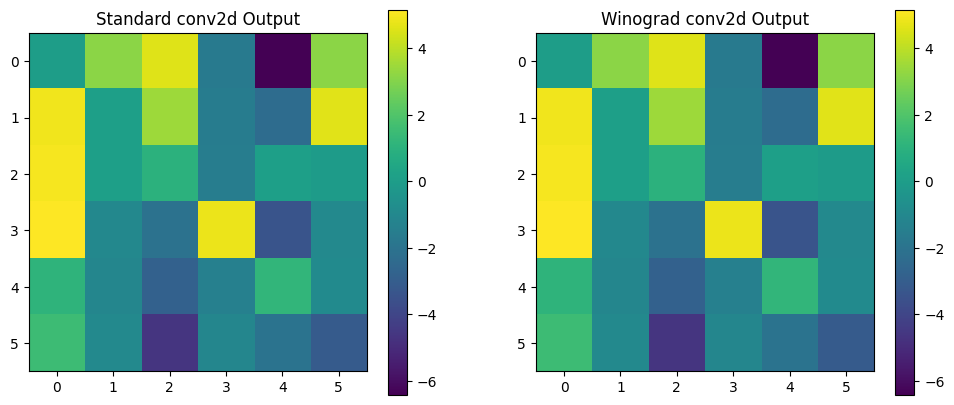

In [ ]:
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------------------------
# Define Winograd Transformation Matrices for F(2x2, 3x3)
#
# B: Input transformation matrix (4×4)
# G: Kernel transformation matrix (4×3)
# A: Output inverse transformation matrix (4×2)
# We define A as 4×2 so that the inverse transform is computed as: y = A^T * Y * A,
# yielding a 2×2 output tile.
# ---------------------------------------------------------------------------
B = torch.tensor([
    [1,  0, -1,  0],
    [0,  1,  1,  0],
    [0, -1,  1,  0],
    [0,  1,  0, -1]
], dtype=torch.float32, device=device)

G = torch.tensor([
    [1,    0,    0],
    [0.5,  0.5,  0.5],
    [0.5, -0.5,  0.5],
    [0,    0,    1]
], dtype=torch.float32, device=device)

# Define A as a 4×2 matrix.
A = torch.tensor([
    [1,  0],
    [1,  1],
    [1, -1],
    [0, -1]
], dtype=torch.float32, device=device)

# Setup: Create an 8x8 single-channel input and a 3x3 kernel.
#
# Standard conv2d (stride=1, no padding) will produce a 6x6 output.
# Winograd F(2x2,3x3) splits the input into overlapping 4x4 tiles, each producing a 2x2 output.
# There will be 3 tiles along each spatial dimension.
N, C, H, W = 1, 1, 8, 8  # Single image, one channel, 8x8 input
input_img = torch.randn(N, C, H, W, device=device)
kernel = torch.randn(1, C, 3, 3, device=device)  # Single 3x3 filter

# Standard convolution for comparison
conv_output = F.conv2d(input_img, kernel, bias=None, stride=1, padding=0)

# Winograd Convolution (F(2x2, 3x3)) Implementation
#
# Steps:
# 1. Transform the 3x3 kernel into Winograd domain: U = G * g * G^T.
# 2. Extract 4x4 tiles from the input using unfold.
# 3. Transform each input tile: X = B * d * B^T.
# 4. Elementwise multiply: Y = X ⊙ U.
# 5. Inverse transform each tile: y = A^T * Y * A, yielding a 2x2 output tile.
# 6. Reassemble the output tiles into the full output.
def winograd_conv2d(input_img, kernel):
    # Transform the kernel: assume single filter and channel.
    g = kernel[0, 0]  # shape: (3,3)
    U = G @ g @ G.t()  # shape: (4,4)

    # For F(2x2, 3x3), tile size is 4x4 and each tile produces a 2x2 output.
    tile_size = 4
    out_tile = 2  # Output tile size
    n_tiles_h = (H - tile_size) // out_tile + 1  # Expected: (8-4)//2 + 1 = 3
    n_tiles_w = (W - tile_size) // out_tile + 1  # Expected: 3

    # Extract overlapping 4x4 tiles from the input
    tiles = input_img.unfold(2, tile_size, out_tile).unfold(3, tile_size, out_tile)
    # tiles shape: (N, C, n_tiles_h, n_tiles_w, 4, 4)

    # Transform input tiles: X = B * d * B^T for each tile.
    X = torch.matmul(B, tiles)         # (4,4) x (N,C,n_tiles_h,n_tiles_w,4,4) -> (N,C,n_tiles_h,n_tiles_w,4,4)
    X = torch.matmul(X, B.t())           # (N,C,n_tiles_h,n_tiles_w,4,4)

    # Elementwise multiplication in Winograd domain.
    Y = X * U  # Broadcasting U (4x4) to each tile

    # Inverse transform for each tile: y = A^T * Y * A.
    # A^T: (2,4), A: (4,2)
    temp = torch.matmul(A.t(), Y)       # (2,4) x (N,C,n_tiles_h,n_tiles_w,4,4) -> (N,C,n_tiles_h,n_tiles_w,2,4)
    y = torch.matmul(temp, A)           # (N,C,n_tiles_h,n_tiles_w,2,4) x (4,2) -> (N,C,n_tiles_h,n_tiles_w,2,2)

    # Reassemble the output tiles into the full output.
    # Permute dimensions to interleave the 2x2 outputs.
    y = y.permute(0,1,2,4,3,5).contiguous()  # shape: (N,C,n_tiles_h,2,n_tiles_w,2)
    output = y.view(N, C, n_tiles_h * out_tile, n_tiles_w * out_tile)
    return output

# Compute Winograd convolution output.
winograd_output = winograd_conv2d(input_img, kernel)

# Compare the outputs (they should be approximately equal, within numerical error).
print("Standard conv2d output:\n", conv_output)
print("Winograd conv2d output:\n", winograd_output)

# Timing Comparison
#
# We measure the average execution time for standard conv2d and our Winograd implementation.
def time_function(func, *args, iterations=1000):
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(iterations):
        _ = func(*args)
    torch.cuda.synchronize()
    return (time.time() - start) / iterations * 1000  # ms per iteration

std_time = time_function(lambda: F.conv2d(input_img, kernel, bias=None, stride=1, padding=0))
winograd_time = time_function(lambda: winograd_conv2d(input_img, kernel), iterations=1000)

print(f"Average Standard conv2d time: {std_time:.2f} ms")
print(f"Average Winograd conv2d time: {winograd_time:.2f} ms")

# Visualization: Plot the outputs side-by-side for visual comparison.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(conv_output[0,0].detach().cpu().numpy(), cmap='viridis')
plt.title("Standard conv2d Output")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(winograd_output[0,0].detach().cpu().numpy(), cmap='viridis')
plt.title("Winograd conv2d Output")
plt.colorbar()
plt.show()

# Winograd Convolution Demo!

## Methodology

This demo implements a Winograd-based convolution (specifically F(2x2, 3x3)) as an alternative to the standard conv2d operation. The process involves transforming a 3x3 kernel into the Winograd domain using pre-defined transformation matrices (G), then dividing an 8×8 input image into overlapping 4×4 tiles and transforming them using the input transformation matrix (B). After elementwise multiplication with the transformed kernel, the inverse transformation (using matrix A) is applied to yield 2×2 output tiles, which are then reassembled to form the full output. The demo also benchmarks the execution time of both the standard convolution and the Winograd implementation over multiple iterations.

## Summary of Implications

Winograd convolution algorithms are a classical optimization technique that reduces the number of multiplications required for small convolutional kernels, leading to lower computational complexity and potentially faster inference. In industrial AI production, especially in models with heavy convolutional layers such as diffusion models, these optimizations can result in significant efficiency gains. This demo highlights how algorithmic improvements at the mathematical level can be leveraged to reduce latency and resource usage, illustrating the practical impact of such techniques on large-scale neural network inference.

## Description of Output

The output displays two main components. First, the numerical outputs from standard conv2d and Winograd conv2d are printed side-by-side, demonstrating that both methods yield approximately the same results within expected numerical error. Second, timing measurements show the average execution times (in milliseconds per iteration) for both approaches—providing insight into the performance of the Winograd implementation. Finally, a pair of visualizations (a side-by-side image plot) compares the standard and Winograd outputs, visually confirming that the Winograd method produces nearly identical feature maps while potentially offering a more efficient computation path.

# One Note on the Viabiity of these demos

Despite their theoretical advantages, our demos for efficient speedups (such as the JIT-fused softmax and Winograd convolution) often run slower than PyTorch’s built-in implementations. This is primarily because the built-in functions are implemented in highly optimized, low-level C++/CUDA code—fine-tuned over years using advanced techniques like kernel fusion, hand-optimized assembly, and deep integration with libraries such as cuDNN. In contrast, our demos, which are written in Python (or use TorchScript), introduce additional overhead from extra tensor transformations, function calls, and reassembly steps. Moreover, techniques like Winograd convolution only yield substantial speedups when applied to very large inputs or under specific conditions; for small or moderately sized tensors, the overhead of the transformations can dominate the computation time. In essence, while our demos effectively illustrate the principles behind these optimizations, replicating the performance of production-grade, hardware-tuned libraries in a simple demo is extremely challenging.


In [5]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip install --upgrade --force-reinstall torch torchvision
!pip install gradio
!pip install diffusers transformers accelerate xformers
!pip install diffusers transformers accelerate xformers gradio --quiet

  Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.5-py3-none-any.whl.metadata (2.6 kB)
  Using cached fsspec-2025.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached

  Using cached MarkupSafe-2.1.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
Using cached MarkupSafe-2.1.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (28 kB)
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
^C
^C
^C


# Stable Diffusion Demo (Hugging Face)

This demo shows how to generate images with Stable Diffusion using two pipeline modes—“Standard” and an “Optimized” version with xFormers memory-efficient attention—via a Gradio interface. Users can experiment with inference steps, guidance scale, image resolution, and diffusion schedulers to see how different choices impact both image quality and performance on GPU. By toggling between “Standard” and “Optimized,” the demo highlights how a focused software optimization (xFormers) can enhance speed and memory usage while producing visually similar outputs.

This demo underscores practical model optimization techniques for deploying large-scale AI systems in production environments, which aligns with your journal club’s focus on industrial AI approaches. Specifically, it illustrates how a specialized library like xFormers can reduce computational costs for complex generative models like Stable Diffusion. This ties back to the club’s broader readings on inference acceleration frameworks (e.g., TensorRT, XNNPACK) and real-world deployment strategies for deep learning models, showing how relatively small code changes can yield significant performance benefits in GPU-based inference.

In [5]:
import torch
import torchvision
from transformers import CLIPTokenizer, CLIPFeatureExtractor
import gradio as gr
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler


print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

Torch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [3]:
# 3. Load Model(s)

# 3.1 Check device (GPU is strongly recommended)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 3.2 Model choices
model_id = "runwayml/stable-diffusion-v1-5"

# Pipeline A: Standard (baseline)
pipe_standard = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)
pipe_standard = pipe_standard.to(device)

# Pipeline B: Optimized (xFormers memory-efficient attention)
pipe_optimized = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)
pipe_optimized = pipe_optimized.to(device)

# Enable xFormers for the “Optimized” pipeline (only works on GPU)
if device == "cuda":
    pipe_optimized.enable_xformers_memory_efficient_attention()
    print("Optimized pipeline: xFormers memory-efficient attention enabled.")

# 4. Define a function for Gradio to call

def generate_image(prompt, steps, width, height, mode, guidance_scale, scheduler_name):
    """
    Generate an image using either the 'Standard' pipeline or the 'Optimized' pipeline.
    Users can also pick among different schedulers for speed or style differences.
    """
    # Pick pipeline
    if mode == "Optimized":
        pipe = pipe_optimized
    else:
        pipe = pipe_standard

    # Switch schedulers on-the-fly
    if scheduler_name == "Euler Ancestral":
        pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
    elif scheduler_name == "DPM Solver":
        pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    # Otherwise, the pipeline's default scheduler remains (PNDM or whatever it was loaded with).

    # Convert to int in case user input is float
    steps = int(steps)
    width = int(width)
    height = int(height)

    if device == "cuda":
        # For GPU, use autocast for half-precision
        with torch.autocast("cuda"):
            image = pipe(
                prompt,
                num_inference_steps=steps,
                width=width,
                height=height,
                guidance_scale=guidance_scale
            ).images[0]
    else:
        # CPU or MPS path, no autocast
        image = pipe(
            prompt,
            num_inference_steps=steps,
            width=width,
            height=height,
            guidance_scale=guidance_scale
        ).images[0]

    return image

# 5. Create the Gradio Interface

with gr.Blocks() as demo:
    gr.Markdown("## Stable Diffusion: Standard vs. Optimized Demo")
    gr.Markdown(
        "Compare two Stable Diffusion pipelines: a baseline vs. one using "
        "xFormers memory-efficient attention. Adjust scheduler, steps, and size "
        "for performance vs. quality."
    )

    with gr.Row():
        prompt = gr.Textbox(
            label="Prompt",
            value="A futuristic cityscape at night, neon lights",
            lines=2
        )

    with gr.Row():
        steps = gr.Slider(
            label="Inference Steps",
            minimum=1,
            maximum=50,
            value=20,
            step=1
        )
        guidance_scale = gr.Slider(
            label="Guidance Scale (CFG)",
            minimum=1,
            maximum=20,
            value=7.5,
            step=0.5
        )

    with gr.Row():
        width = gr.Slider(
            label="Width",
            minimum=64,
            maximum=1024,
            step=64,
            value=512
        )
        height = gr.Slider(
            label="Height",
            minimum=64,
            maximum=1024,
            step=64,
            value=512
        )

    with gr.Row():
        mode = gr.Radio(
            label="Pipeline Mode",
            choices=["Standard", "Optimized"],
            value="Standard"
        )
        scheduler_name = gr.Dropdown(
            label="Scheduler",
            choices=["Default", "Euler Ancestral", "DPM Solver"],
            value="Default",
        )

    generate_btn = gr.Button("Generate Image")
    output_image = gr.Image(label="Generated Image")

    # The key fix: pass the "inputs" to the function
    generate_btn.click(
        fn=generate_image,
        inputs=[prompt, steps, width, height, mode, guidance_scale, scheduler_name],
        outputs=output_image
    )

demo.launch(debug=True, share=True)

NameError: name 'torch' is not defined

# Stable Diffusion: Standard vs. Optimized Demo

## Methodology

This demo runs two variants of a Stable Diffusion pipeline: a **Standard** (baseline) pipeline and an **Optimized** pipeline that uses xFormers memory-efficient attention (available only on GPU). The code loads the same pretrained model ("runwayml/stable-diffusion-v1-5") for both pipelines and toggles the xFormers optimization on the Optimized pipeline when a GPU is available. The Gradio interface allows users to modify key parameters—such as the text prompt, inference steps, guidance scale, image resolution, and scheduler—to observe how these settings influence the output image quality and performance.

## Summary of Implications

This demo illustrates practical optimization in generative model inference. By switching between the Standard and Optimized pipelines, users can explore how enabling xFormers memory-efficient attention may improve inference speed and reduce memory usage on GPUs. The adjustable parameters—like the number of inference steps, guidance scale (which controls how strictly the model follows the prompt), and the resolution—highlight the trade-offs between generation quality, latency, and resource consumption. Additionally, the scheduler toggle (with options like Default, Euler Ancestral, and DPM Solver) showcases how different diffusion strategies can impact the style and speed of image generation, providing a hands-on view of the optimizations discussed in our journal club.

## Description of Output

When you run the demo, you’ll see an interactive Gradio interface with several toggles:
- **Prompt:** Enter any textual description for image generation.
- **Inference Steps:** Adjust the number of diffusion iterations; more steps generally yield higher quality at the cost of speed.
- **Guidance Scale (CFG):** Set the strength of the model’s adherence to the prompt; higher values can produce more on-target images.
- **Width & Height:** Control the resolution of the output image, balancing detail against computational demand.
- **Pipeline Mode:** Switch between “Standard” (baseline, no extra optimizations) and “Optimized” (enabling xFormers memory-efficient attention for potentially faster and more memory-efficient inference on GPU).
- **Scheduler:** Choose between Default, Euler Ancestral, and DPM Solver schedulers to experiment with different strategies for noise reduction and image refinement.
  - **Default:** The standard scheduler (typically DDIM or PNDM) that the model was trained with, offering a balanced trade-off between speed and quality.
  - **Euler Ancestral:** Uses an Euler-based update with a stochastic component for potentially sharper images and varied aesthetics, though sometimes with increased variance.
  - **DPM Solver:** A recent scheduler designed to accelerate the diffusion process by solving the diffusion ODE more efficiently, often achieving similar or improved visual quality with fewer steps.


Overall, the demo provides a comprehensive, interactive experience to explore how various optimization strategies and parameter settings affect the performance and quality of image generation in a real-world, production-like scenario.

In [ ]:
demo.launch()